# Avaliação 08 - Implementação de Filtros Digitais

---

### Projeto 2: Butterworth por Transformação Bilinear

ENGC63 - 2021.2

João Carneiro e Osmar Oliveira

# Trabalho de Processamento Digital de Sinais (ENGC63)


- Projete, a partir de um filtro passa-baixas Butterworth de sexta ordem, um filtro discreto passa-baixas com frequência de corte (-3dB) igual ω c = 2π/3, usando o método da invariância da resposta
impulsiva (**Projeto1**) ou usando o método de transformação bilinear (**Projeto2**) 

- Faça a implementação sob forma direta e sob forma em cascata. 

- Represente os coeficientes em ponto flutuante (ex.: 0, 00423578 = 0, 423578 × 10 − 2 ) e vá diminuindo o número de casas decimais após a vı́rgula nas formas direta e em cascata para verificar a sensibilidade à quantização de parâmetros. 

- Trace a curva do módulo da resposta em freqência em dB para os casos de precisão infinita e precisão finita. 
Em seguida, para a representação em forma direta, refaça os filtros com as 3 transformações em frequência a seguir (Z − 1 = −z − 1 ; Z − 1 = z − 2 e Z − 1 = −z − 2 ) e trace a curva do módulo em dB da resposta em frequência resultante. 

- Use os seus filtros para processar um sinal de áudio de sua preferência, ouça os resultados e os avalie perceptualmente. Avalie, também, o espectro em função do tempo, do sinal de entrada e de saída utilizando um espectrograma.


## Imports

In [228]:
import numpy as np
from scipy import signal, fft
import matplotlib.pyplot as plt
import math
from IPython.display import display, Math

## Funções Auxiliares

In [243]:
def to_string(number):
    exp = np.floor(np.log10(np.abs(number))).astype(int)
    num = number * 10.0**(-exp - 1)
    return r"{0} \times 10^{{{1}}}".format(num, exp+1)

num = 1.266485216936955e-12
num = round(num, 12+16)
display(Math(to_string(num)))

<IPython.core.display.Math object>

## Filtro Discreto Passa-Baixas

Transformação bilinear de um filtro Butterworth

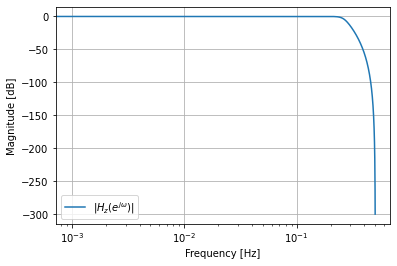

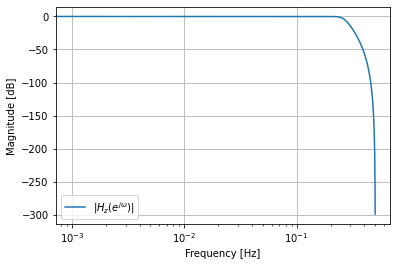

In [240]:
ordem = 6       # Ordem do Butterworth
Wc = 2*np.pi/3  # Freq de corte


# Cria filtros Butterworth:

# Saída TF para a Forma Direta
filts_tf = signal.lti(*signal.butter(ordem, Wc, btype='lowpass', analog=True, output='ba'))
# Saída ZPK para a Forma em Cascata
filts_zpk = signal.lti(*signal.butter(ordem, Wc, btype='lowpass', analog=True, output='zpk'))


# Converte Butterworth por Transformação Linear:

# Saída TF para a Forma Direta
filtz_tf = signal.dlti(*signal.bilinear(filts_tf.num, filts_tf.den))
# Saída ZPK para a Forma em Cascata
filtz_zpk = signal.dlti(*signal.bilinear_zpk(filts_zpk.zeros, filts_zpk.poles, filts_zpk.gain, fs=1))

# Calcula resposta em frequência
wz, hz = signal.freqz(filtz_tf.num, filtz_tf.den)
wz2, hz2 = signal.freqz_zpk(filtz_zpk.zeros, filtz_zpk.poles, filtz_zpk.gain)

# Plota resposta em frequência do filtro resultante
plt.semilogx(wz*1/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

plt.figure(2)
plt.semilogx(wz2*1/(2*np.pi), 20*np.log10(np.abs(hz2).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()



## Função para Forma Direta I

In [ ]:
# Encontra saída pela Forma Direta I
def direct_i(x, b, a):
    input_size = len(x)
    M = len(b) - 1
    N = len(a) - 1

    y = np.empty(input_size)

    # Função para retornar 0 em caso de índice inválido
    def get_value(list, index):
        try:
            return list[index]
        except:
            return 0

    # Percorre por toda entrada
    for n in in range(input_size):
        # Somatórios resultantes da Forma Direta I
        for i in range(M+1):
            y[n] += b[i] * get_value(x, n - 1)
        for j in range(1, N+1):
            y[n] -= a[j] * get_value(y, n - j)
    
    return y

## Função para Forma em Cascata

In [246]:
# Encontra saída pela Forma em Cascata
def cascade(x, z, p, k):

    # Cria filtros para cada Pólo
    filterList = []
    for i in p:
        filterList.append(signal.ZerosPolesGain(0, [i], 1))

    # Cria filtro para cada Zero
    for i in z:
        filterList.append(signal.ZerosPolesGain([i], 0, 1))


    x = np.array([1, 0, 1, 0, 1, 0]) # colocar sinal de entrada aqui
    for i in filterList:
        tout, yout, x = i.output(x, [1, 2, 3, 4, 5, 6])
    plt.figure(2)
    plt.plot(x)
    return x*k


## 

# Transformação $Z^{-1} = -z^{-1}$##

In [258]:
def first_transf(z, p, k):
    z = z*-1
    p = p*-1

    return z, p, k


(array([ 1, -1, -2, -3]), array([-1, -2, -3, -4]), 5)


# Transformação $Z^{-1} = z^{-2}$#

# Transformação $Z^{-1} = -z^{-2}$#